<div class="alert alert-block alert-success">

### Data analytics practice with python using the **penguins** dataset from `seaborn` 🧊 🐧
**Author:** Ellie Taagen   

**Date:** March 2025

**Read Me:** for this notebook's features to render please open in [nbviewer](https://nbviewer.org/github/etaagen/python-projects/blob/main/penguinProject.ipynb), instead of GitHub.  

### 📓 Table of contents <a class='anchor' id='top'></a>
- [Quickstart](#quickstart)
- [Explore the data](#explore-the-data)
- [Inspect missing values](#inspect-missing-values)
- [Pearson Correlation](#pearson-correlation)
- [Check for outlier](#check-for-outlier)
- [Practice subset, filter, sort](#practice-subset,-filter,-sort)
- [Cutest penguin function](#cutest-penguin-function)
- [Summary](#summary)


</div>

### Quickstart <a class="anchor" id="quickstart"></a>
We are going to load the libraries and dataset

In [49]:
###### Import libraries ######
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# import data
penguins = sns.load_dataset("penguins")

### Explore the data <a class="anchor" id="explore-the-data"></a>

These are some data exploration steps you should always take with a new dataset 

In [50]:
print(type(penguins)) # check the type of the dataset, should be a DataFrame
print(penguins.head()) # look at the first few rows of the dataset 
print(penguins.shape) # check the shape of the dataset
print(penguins.isna().sum()) # check for missing values
# print the unique values for categorical columns
print(penguins['species'].unique())
print(penguins['island'].unique())
print(penguins['sex'].unique())

<class 'pandas.core.frame.DataFrame'>
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female  
(344, 7)
species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64
['Adelie' 'Chinstrap' 'Gentoo']
['Torgersen' 'Biscoe' 'Dream']
['Male' 'Female' nan]


### Inspect missing values <a class="anchor" id="inspect-missing-values"></a>
Create a function for plotting missing categorical variables versus quantative variables

               mean         std
        body_mass_g body_mass_g
sex                            
Female  3862.272727  666.172050
Male    4545.684524  787.628884


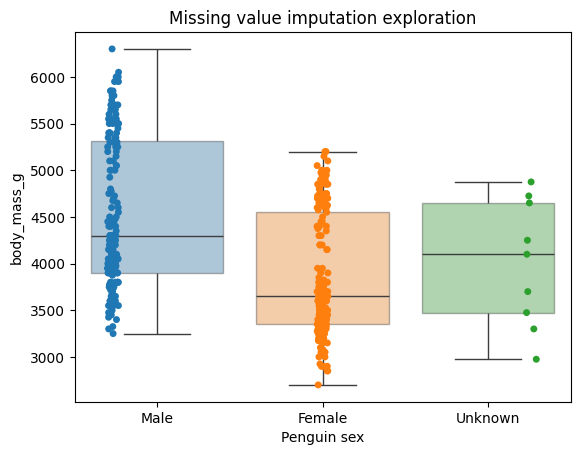

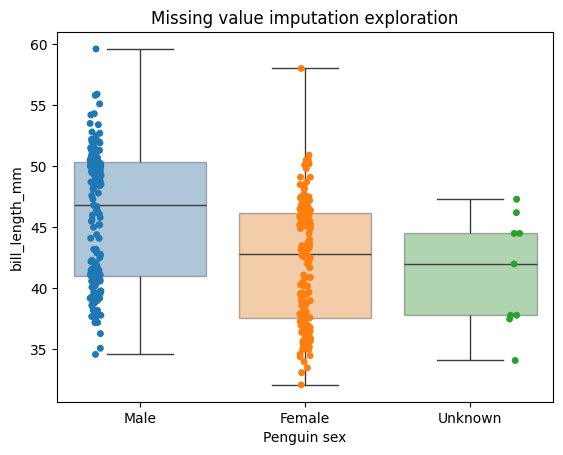

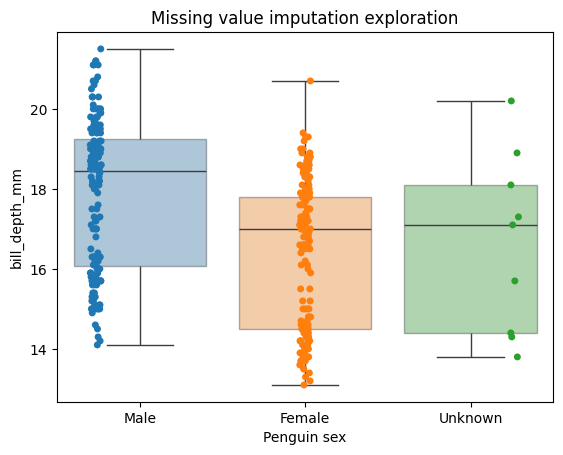

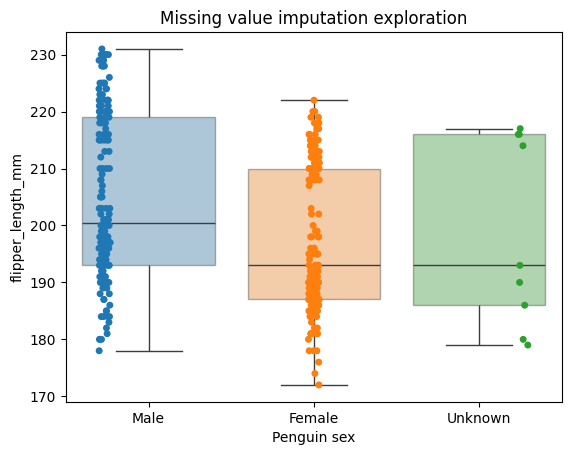

In [51]:
# Decide how to handle the na values
# some options are to drop the na values, replace with the mode (not as applicable to categorical variables), or impute/predict
penguins[penguins['bill_length_mm'].isna() == True] # looks like this is missing for all the quantiative columns, let's delete
# are any of the variables correlated with the missing sex values? 
print(penguins.pivot_table(index = 'sex', values = 'body_mass_g', aggfunc = ['mean', 'std']))

#print(penguins[penguins['sex'].isna() == True][['sex', 'body_mass_g']]) # maybe you could impute based on the quantitative values 

# make a plot with the mean, std, and missing sex values 
# to include missing values give them a name, there is no dropna = False argument for hue in sns
penguins_plot = penguins.copy()
penguins_plot['sex'] = penguins_plot['sex'].fillna('Unknown')
# make a function to plot sex vs quantitative values
def plot_missing_penguin(input_data, quant_value):
    """
    Function to plot the missing penguin sex values against a quantitative variable
    """
    # Function body - code to be executed
    base_plot = sns.boxplot(data = input_data, x = 'sex', y = quant_value, hue='sex', boxprops={'alpha': 0.4})
    sns.stripplot(data = input_data, x= "sex", y= quant_value,
        hue="sex", dodge=True, ax = base_plot)
    plt.xlabel("Penguin sex")
    plt.ylabel(quant_value)
    plt.title("Missing value imputation exploration")
    return plt.show()

plot_variables = ['body_mass_g', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']
for variable in plot_variables:
    plot_missing_penguin(input_data = penguins_plot, quant_value = variable)


#### Pearson Correlation <a class="anchor" id="pearson-correlation"></a>
Create a function to loop over the columns and measure correlation and p-values   

In [52]:
# replace values to have a quantiative sex value
penguins_onehot = pd.get_dummies(penguins_plot, columns=['sex', 'island', 'species'], drop_first=True)
# note that covariance is senstive to scale (+, -, and 0 relationships)
# covaraince is a stepping stone to more interesting things like PCA and measuring correlation 
# confidence in correlation is dependent on sample size (p value)
# -1 or 1 = can draw a straight line through every data point
# note a small p-value doesn't mean the correlation is strong, it just might tell you that adding more data doesn't change the correlation
# and correlation is still hard to interpret - it quantifies the strength of a linear relationship

# an R2 value tells us even more!

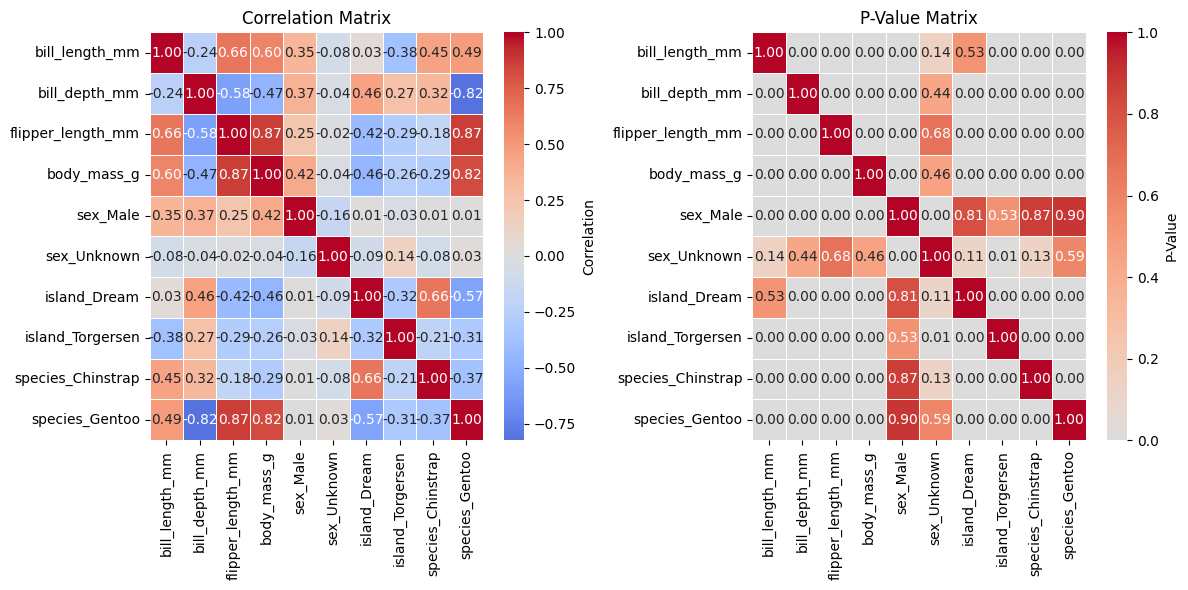

In [53]:
# pearson correlation can add the p-value
def corr_with_pvalues(df):
    '''
    Function calculates correlations and p-values, will convert input to be numeric and no missing values
    '''
    # does not work without missing values 
    df = df.dropna(axis = 'index') # Drop rows with missing values
    # does not work with categorical variables
    df = df.astype(float)

    cols = df.columns
    corr_matrix = df.corr()
    pval_matrix = pd.DataFrame(np.ones(corr_matrix.shape), columns=cols, index=cols)  # Initialize with 1s

    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):  # Avoid redundant calculations
            corr, pval = stats.pearsonr(df[cols[i]], df[cols[j]])
            corr_matrix.iloc[i, j] = corr_matrix.iloc[j, i] = corr  # Fill correlation
            pval_matrix.iloc[i, j] = pval_matrix.iloc[j, i] = pval  # Fill p-value

    return corr_matrix, pval_matrix

# Get correlation and p-value matrices
corr_matrix, pval_matrix = corr_with_pvalues(penguins_onehot)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, center=0, ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Correlation Matrix')

sns.heatmap(pval_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, center=0, ax=axes[1], cbar_kws={'label': 'P-Value'})
axes[1].set_title('P-Value Matrix')

plt.tight_layout()
plt.show()

# multicolinearity issues:
# If two variables convey almost the same information, it’s hard to tell which one is driving the relationship with the target variable.
# this also risks overfitting the model to the training data, and not doing well on test/new data
# we see some high correlations here with significant p-values
# it looks like body mass and flipper length are highly correlated, be mindful if we want to do any modeling
# the Gentoo species is heavy with big wings and small bill depth
# maybe something like PCA would best account for the variance.


#### Check for outlier <a class="anchor" id="check-for-outlier"></a>
Assess the distribution of variables first 

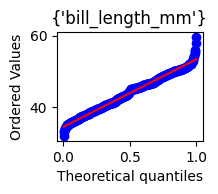

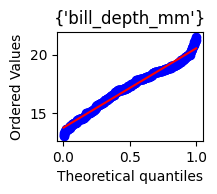

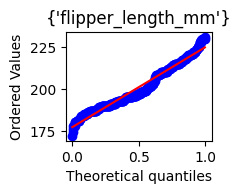

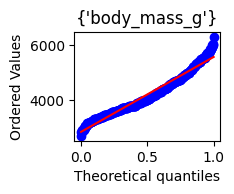

[Empty DataFrame
Columns: [bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g]
Index: [], Empty DataFrame
Columns: [bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g]
Index: [], Empty DataFrame
Columns: [bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g]
Index: [], Empty DataFrame
Columns: [bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g]
Index: []]


In [54]:
# ultimately there are not many missing values so it would be appropriate to delete. 
penguins_drop = penguins.dropna(axis = 'index')

# sometime should learn about sklearn impute 
# https://www.geeksforgeeks.org/handling-missing-data-with-iterativeimputer-in-scikit-learn/

# also good to check for outlier
# Z-score (good for normally distributed data) 
# data rarely has a normal distribution 

# use a QQ plot to check for normality in quantitative variables
# x axis is quantiles of a normal distribtuion, and y is the actual data quantiles
# so if data is normally distributed most dots are on the line 
penguins_quant = penguins_drop.drop(columns=["species", "island", "sex"])

#range(0, penguins_quant.shape[1])
#penguins_quant.iloc[:, 3]

for i in range(0, penguins_quant.shape[1]):
    plt.subplot(3, 3, i+1)
    stats.probplot(penguins_quant.iloc[:, i], dist="uniform", plot=plt) # dist = "norm"
    plt.title({penguins_quant.columns[i]})
    plt.show()

# these fit more of a uniform distirbution! 
# can run the IQR method but no outliers expected with a uniform dist.
penguin_outliers = []
for i in range(0, penguins_quant.shape[1]):
    Q1 = penguins_quant.iloc[:, i].quantile(0.25)
    Q3 = penguins_quant.iloc[:, i].quantile(0.75)
    IQR = Q3 - Q1

    outliers = penguins_quant[(penguins_quant.iloc[:, i] < (Q1 - 1.5 * IQR)) | penguins_quant.iloc[:, i] > (Q3 + 1.5 * IQR)]
    penguin_outliers.append(outliers)

print(penguin_outliers) # no outliers! this is expected with a uniform dist.

### Practice subset, filter, sort <a class="anchor" id="practice-subset,-filter,-sort"></a>

In [55]:
# for loop and if statement 
# dictionary, {key: value}
penguin_data = { # define a df name, and the df 
    "penguins": penguins,
    "penguins_plot": penguins_plot,
    "penguins_onehot": penguins_onehot,
    "penguins_drop": penguins_drop
}


for name, df in penguin_data.items():
    if df.isna().sum().sum() == 0:
        print(f"{name}: no missing values")
        # bracket is like str()
   # elif
   # pass statements help you make filler as you're working on the code
   # break or continue statements
    else:
        print(f"{name}: there are {df.isna().sum().sum()} missing values")

### how many female vs male penguins are there in each category
print(penguins_drop.pivot_table(index=["island", "species"], columns="sex", aggfunc="size", fill_value=0))

### sort_values on heaviest penguin species
print(penguins_drop[["species", 'body_mass_g']].sort_values(by = 'body_mass_g', ascending=False))


penguins: there are 19 missing values
penguins_plot: there are 8 missing values
penguins_onehot: there are 8 missing values
penguins_drop: no missing values
sex                  Female  Male
island    species                
Biscoe    Adelie         22    22
          Gentoo         58    61
Dream     Adelie         27    28
          Chinstrap      34    34
Torgersen Adelie         24    23
       species  body_mass_g
237     Gentoo       6300.0
253     Gentoo       6050.0
297     Gentoo       6000.0
337     Gentoo       6000.0
299     Gentoo       5950.0
..         ...          ...
116     Adelie       2900.0
54      Adelie       2900.0
64      Adelie       2850.0
58      Adelie       2850.0
190  Chinstrap       2700.0

[333 rows x 2 columns]


### Cutest penguin function <a class="anchor" id="cutest-penguin-function"></a>

Obviously, the cutest penguin is the smallest.

The cutest penguin is a Female Chinstrap from Dream island.


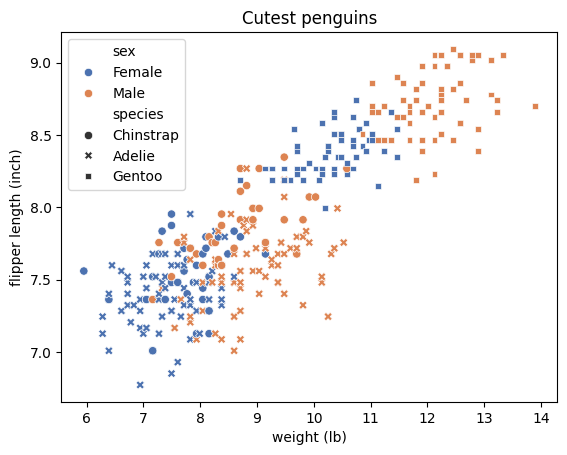

(None, None)

In [56]:
### writing functions
def cutest_penguin(df):
    """
    Function to find the cutest penguin - heaviest and shortest flipper
    parameter is the dataframe
    """
    cutest = df.sort_values(by = ['body_mass_g', 'flipper_length_mm'], ascending= [True, True]) #inplace = True would change the original df
   
    # convert to us units
    # 1 g = 0.00220462 lbs
    # 1 mm = 0.0393701 inch
    cutest['weight_lb'] = cutest['body_mass_g'] * 0.00220462
    cutest['flipper_inch'] = cutest['flipper_length_mm'] * 0.0393701

    
    base_plot = sns.scatterplot(data = cutest, x = 'weight_lb', y = 'flipper_inch', hue ='sex', style = 'species', palette = 'deep')
    plt.xlabel("weight (lb)")
    plt.ylabel('flipper length (inch)')
    plt.title("Cutest penguins")
    # return the text and plot
    return print("The cutest penguin is a " + str(cutest.iloc[0, 6]) + " " + str(cutest.iloc[0, 0]) + " from " + str(cutest.iloc[0, 1]) + " island." ), plt.show()

    
# call function
cutest_penguin(penguins_drop)


<div class="alert alert-block alert-success">

### Summary <a class="anchor" id="summary"></a>

In this notebook we practiced:  
- importing libraries and data 
- exploratory data analysis including missing values, outlier, correlations 
- creating plots with seaborn
- writing loops and functions to remove redundancy  

Some additional exploration and coding could include:  
- writing functions in a .py and importing them for more readability 
- a classification problem: can you predict the penguin's species? 


### That's all for now!  
<img style="float: center;" src="chick.jpeg">


<div>
